# Two Body Problem: Elliptical Orbits 

This is the most general case of a Keperian orbit.<br>
Two bodies orbit each other under the influence of gravity.  The orbit is an ellipse with the primary at one focus.<br>
See https://en.wikipedia.org/wiki/Kepler_orbit for a detailed discussion on the theory and history of this problem.
See https://en.wikipedia.org/wiki/Two-body_problem for the reduction of the general two body problem to two coupled instances of the restricted two body problem.  The trivial one describes the center of mass (which drifts in a straight line), and the non-trivial one describes the relative displacement between the two orbiting bodies.

In [1]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np
import datetime

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from g2b_data import make_traj_g2b, make_data_g2b, make_datasets_g2b
from g2b_data import make_datasets_solar, make_datasets_binary
from g2b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Lightweight serialization
fname = '../data/g2b/g2b.pickle'
vartbl = load_vartbl(fname)

![title](../figs/web/orbital-elements.png)

**Variable Names of Six Keplerian Orbital Elements**
* `a` - semi-major axis; size of the ellipse; mean of periapsis and apoapsis distances
* `e` - eccentricity; shape of the ellipse.  e=0 is a circle, e=1 is a line.  $e^2 = 1 - b^2 / a^2$
* `inc` - inclination; angle between orbital and ecliptic planes
* `Omega` - longitude of the asending node; undefined when inc=0
* `omega` - argument of pericenter; true anomaly where body is closest to the primary.
* `f` - true anomaly; angle of the orbiting body in its orbital plane

**Two Additional Elements**
* `M` - mean anomaly; area swept out by the orbiting body, normalized so a full orbit is $2 \pi$.  Because of the rule of equal area in equal time, a.k.a. conservation of angular momentum, the mean anomly is linear in time
* `N` - mean motion; rate at which mean anomly changes, i.e. $2 \pi / T$ where $T$ is the orbital period

### Generate and Visualize One Example Orbital Path

The module `g2b_data.py` includes functions used to generate training data for the (general) two body problem.<br>
The function `make_traj_g2b` generates a single trajectory for the G2B problem.  It takes as inputs the masses of the two bodies, `m1` and `m2`; and the six traditional orbital elements (`a`, `e`, `inc`, `Omega`, `omega`, `f`).  It creates a new Rebound simulation with two particles: the sun and the orbiting body.  The sun has mass 1.0 in solar mass units, and initial position and velocity 0.  The orbiting body is defined as a "test particle" with a mass of 0, and its initial position and velocity are assigned by Rebound based on the orbital elements.  The orbit is evaluated at intervals of one "day" (1/365 of a year) for a period of `n_years`.  Here I used 2 years, leading to 731 data points counting both the start and end point.  The results are returned in two Dict objects named inputs and outputs.<br>
**Inputs**
* t - vector of times at which the orbit was sampled
* q1_init - initial position of body 1; 3 vector
* q2_init - initial position of body 2; 3 vector
* v1_init - initial velocity of body 1; 3 vector
* v2_init - initial velocity of body 2; 3 vector
* m1 - mass of body 1 in solar masses
* m2 - mass of body 2 in solar masses

**Outputs**
* q1 - orbital positions of body 1 over time; Nx3 matrix
* q2 - orbital positions of body 2 over time; Nx3 matrix
* v1 - orbital velocitiy of body 1 over time; Nx3 matrix
* v2 - orbital velocitiy of body 2 over time; Nx3 matrix
* a1 - orbital acceleration of body 1 over time; Nx3 matrix
* a2 - orbital acceleration of body 2 over time; Nx3 matrix
* q1_rec - recovered initial position of body 1; duplicate of q1_init
* q2_rec - recovered initial position of body 2; duplicate of q2_init
* v1_rec - recovered initial velocity of body 1; duplicate of v1_init
* v2_rec - recovered initial velocity of body 2; duplicate of v2_init
* T - the kinetic energy of the system; $T = \frac{1}{2} \sum_{i=1}^{2}{m_i |v_i|^2}$
* U - the potential energy of the system; $U = \frac{-G m_1 m_2}{r}$ where $r = |q1 - q2|$ is the distance
* H - the total energy in the system $H = T + U$
* P - the momentum, $P = \sum{m_i \cdot v_i}$
* L - the angular momentum, $L = \sum{q_i \times m_i v_i}$

In [5]:
import rebound
import numpy as np

In [6]:
# Generate one example trajectory with an eccentric orbit and a light orbiting body
# This should match R2B example
m1 = 1.0
m2 = 1.0E-6
a = 1.0
e = 0.2
inc = 0.02
Omega = 0.0
omega = 0.0
f = 0.0
n_years = 2

inputs_traj, outputs_traj = make_traj_g2b(m1=m1, m2=m2, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f, n_years=n_years)

# Combined dict
data_traj = {**inputs_traj, **outputs_traj}

# Review the fields
print('Input fields:', list(inputs_traj.keys()))
print('Output fields:', list(outputs_traj.keys()))

Input fields: ['t', 'q0', 'v0', 'm']
Output fields: ['q', 'v', 'a', 'q0_rec', 'v0_rec', 'T', 'U', 'H', 'P', 'L']


In [7]:
# Plot style 
plot_style()

In [8]:
# fig, ax = plot_orbit_q(data_traj, 1)

In [9]:
# fig, ax = plot_orbit_q(data_traj, 2)

In [10]:
import matplotlib.pyplot as plt

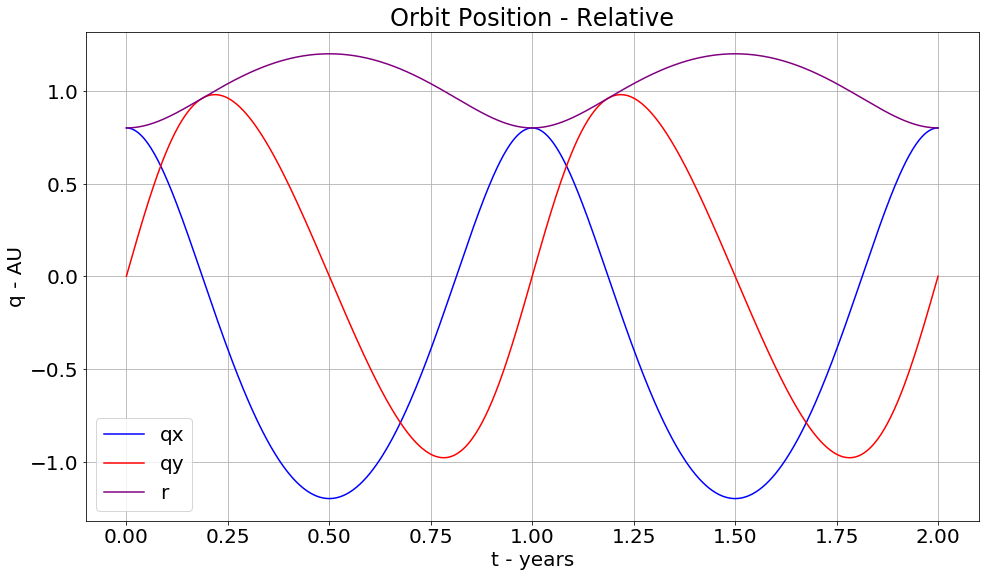

In [11]:
fig, ax = plot_orbit_q(data_traj, 0)

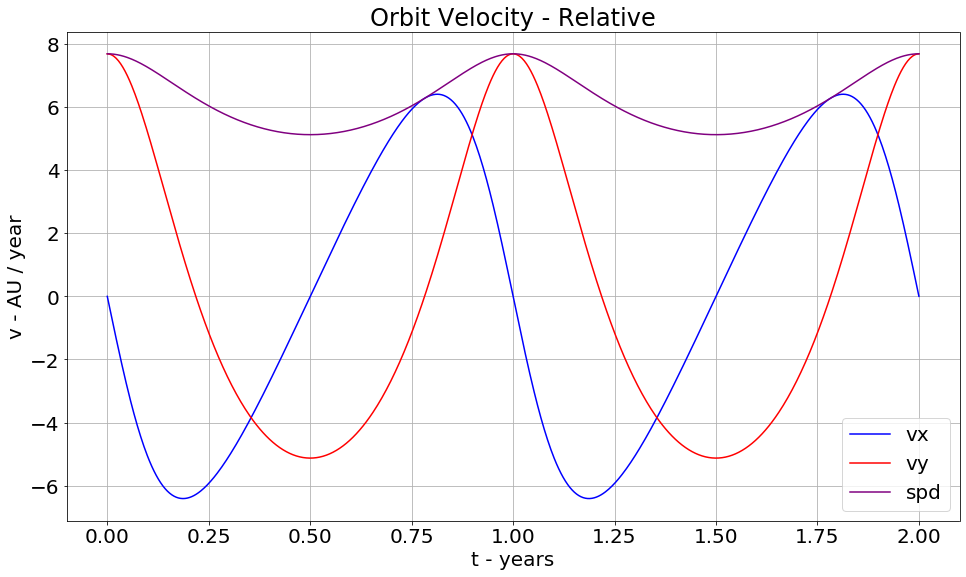

In [12]:
fig, ax = plot_orbit_v(data_traj, 0)

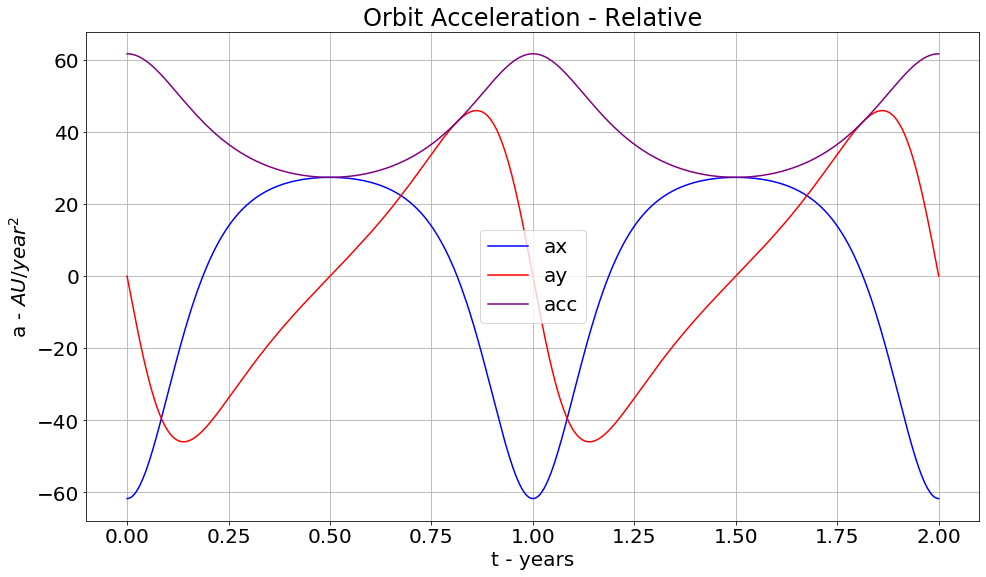

In [13]:
fig, ax = plot_orbit_a(data_traj, 0)

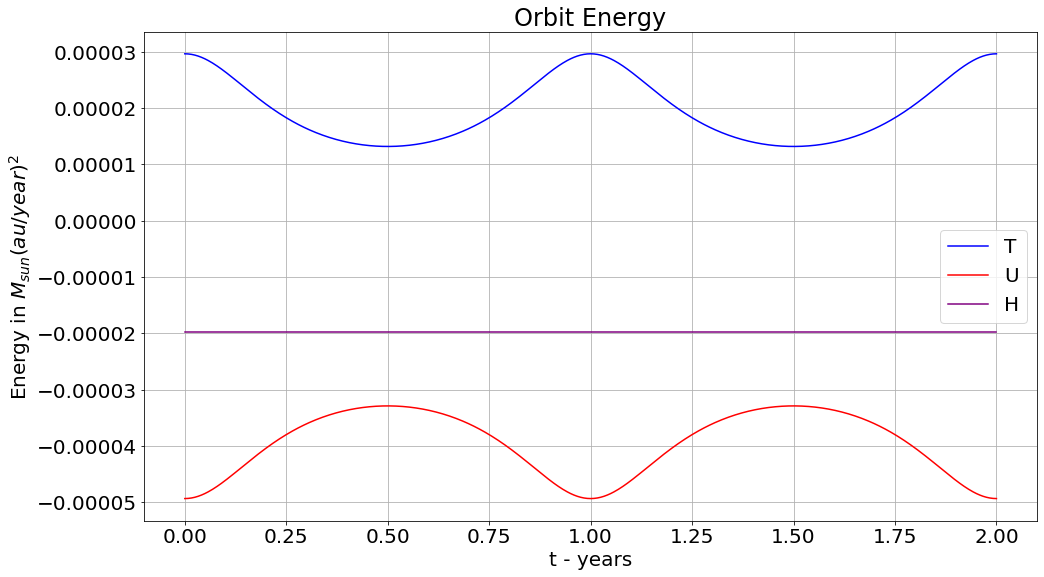

In [14]:
fig, ax = plot_orbit_energy(data_traj)

In [15]:
# Generate one example trajectory with an eccentric orbit and a heavy orbiting body
m1 = 1.0
m2 = 1.0
a = 1.0
e = 0.2
inc = 0.02
Omega = 0.0
omega = 0.0
f = 0.0
n_years = 2

inputs_traj, outputs_traj = make_traj_g2b(m1=m1, m2=m2, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f, n_years=n_years)

# Combined dict
data_traj = {**inputs_traj, **outputs_traj}

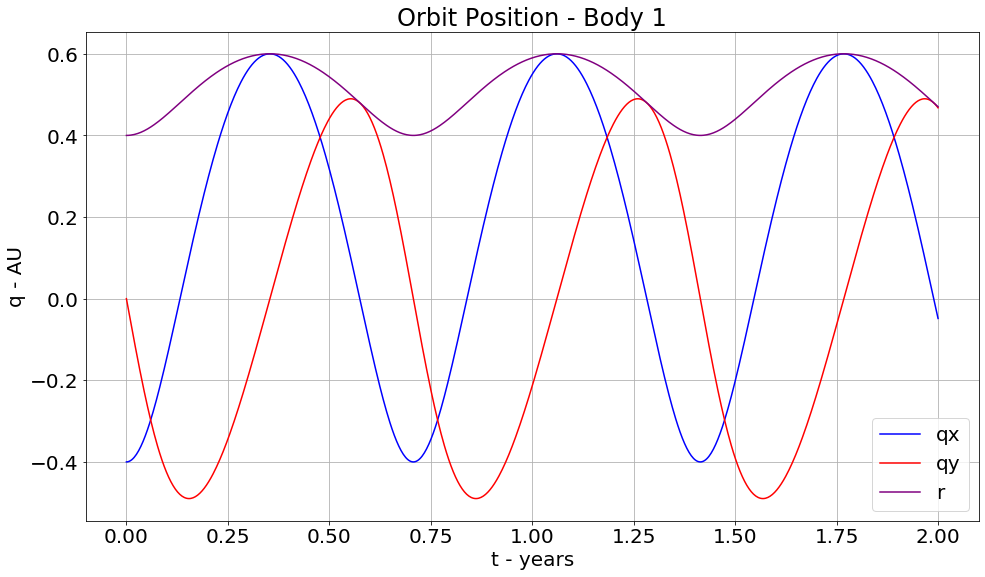

In [16]:
fig, ax = plot_orbit_q(data_traj, 1)

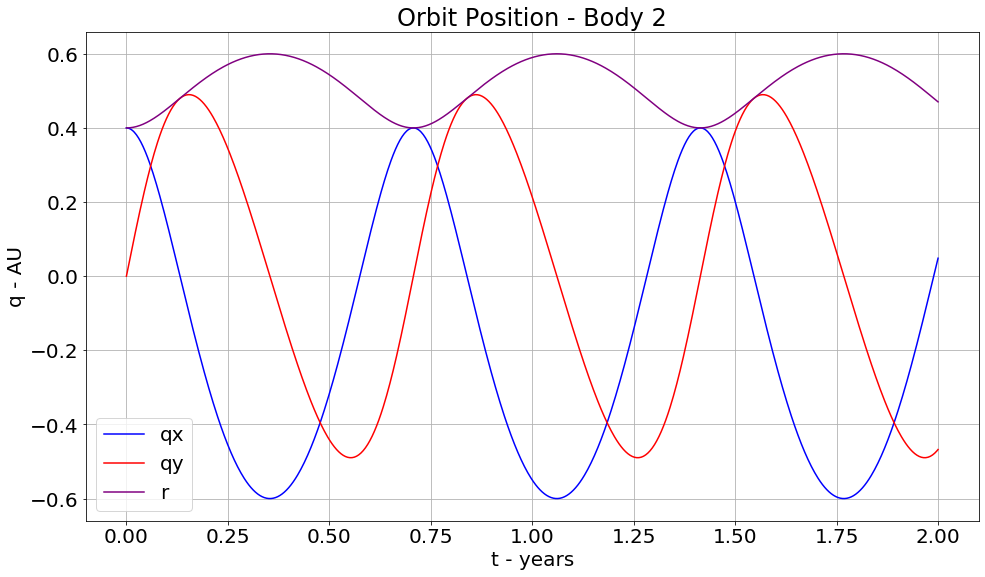

In [17]:
fig, ax = plot_orbit_q(data_traj, 2)

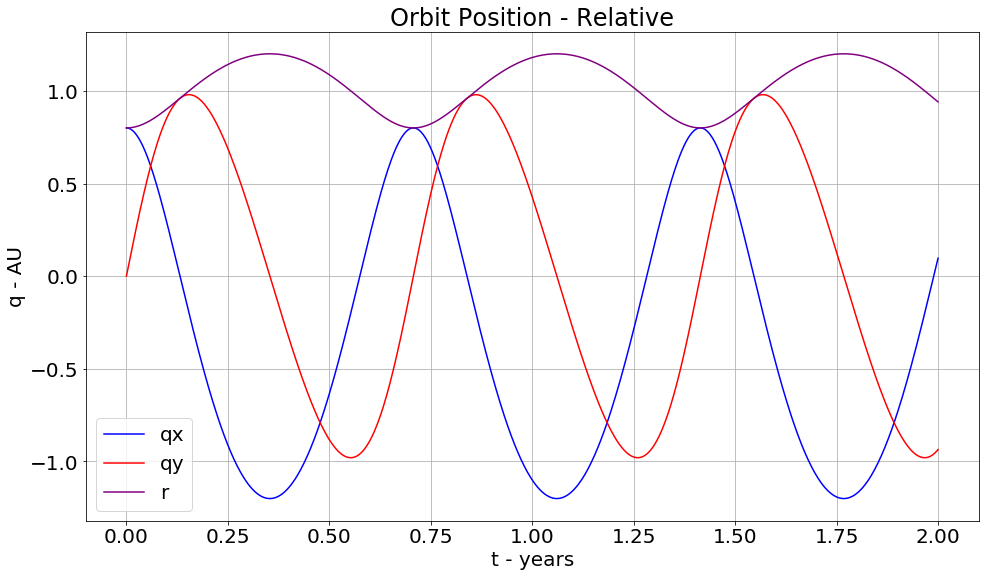

In [18]:
fig, ax = plot_orbit_q(data_traj, 0)

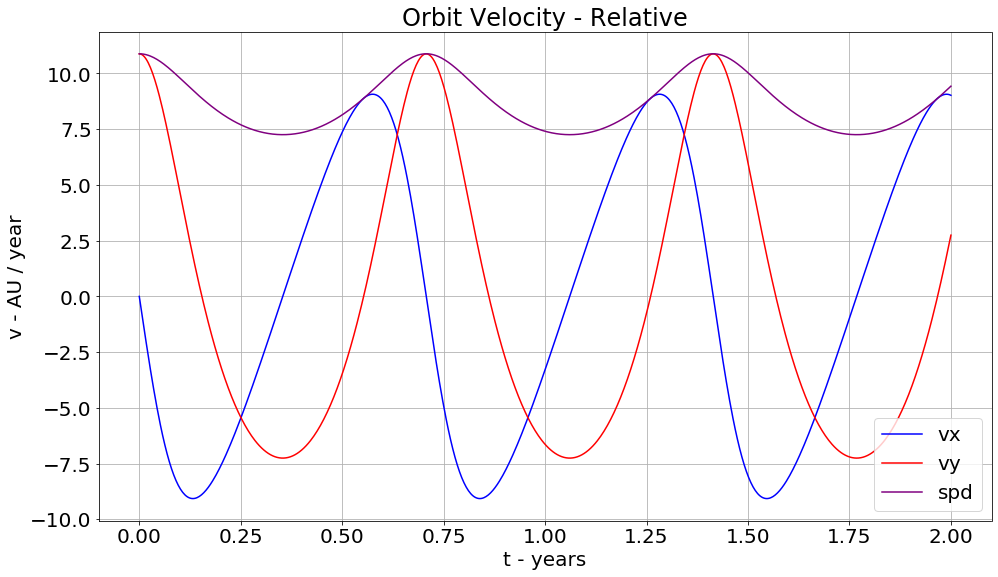

In [19]:
fig, ax = plot_orbit_v(data_traj, 0)

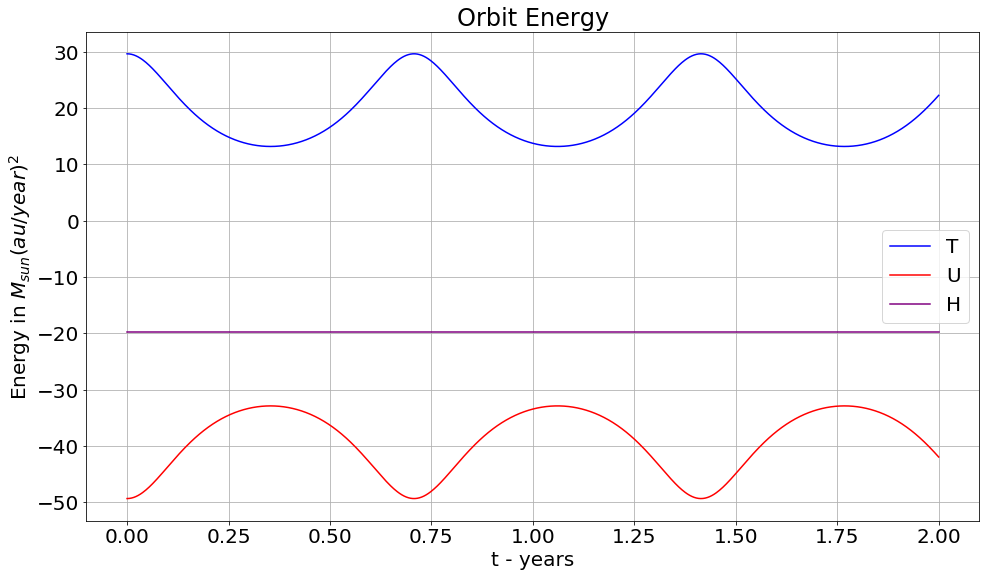

In [20]:
fig, ax = plot_orbit_energy(data_traj)

### Generate Training Data with a Range of Orbital Parameters

The function `make_train_g2b` creates training data for the general 2 body problem in the form of dictionaries of numpy arrays.  These are analogous to the outputs of `make_traj_r2b`, but there is an outer index of `n_traj` different trajectories.  The input `m_max` is the maximum mass of the second body in solar units; the first body always has mass equal to 1 solar unit.  The inputs `a_min`, `a_max`, `e_max`, and `inc_max` determine the sampling ranges for the parameters `a`, `e` and `inc` of the orbital elements of the starting configuration.  The other orbital elements (`Omega`, `omega`, `f`) are sampled over the full range of admissible values.<br>
The function `make_datasets_r2b` generates three tensorflow Dataset objects for train, validation and test, respectively.  Data is generated in the form of Numpy arrays using `make_train_g2b` because it is easier to serialize in that format.  The function checks on disk to see if the data is already available, and if so, loads it.  Otherwise it generates and then saves it.  Effective serialization is critical because the data set is expensive to generate.

In [21]:
# Inputs for make_train_g2b
m_max = 0.002
n_traj = 10
n_years = 2
a_min = 0.50
a_max = 32.0
e_max = 0.20
inc_max = np.pi/4.0
seed = 42

In [22]:
# Test make_data_g2b
inputs, outputs= make_data_g2b(n_traj=n_traj, n_years=n_years, a_min=a_min, a_max=a_max, 
                                e_max=e_max, inc_max=inc_max, seed=seed)

In [23]:
# Inputs for make_datasets_g2b
n_traj = 100
vt_split = 0.20
n_years = 2

# The batch size (encapsulated in make_datasets_earth and make_datasets_solar)
batch_size = 64

In [24]:
# Create DataSet objects for toy size problem - binary type orbits
ds_small_trn, ds_small_val, ds_small_tst = make_datasets_binary(n_traj=n_traj, vt_split=vt_split, n_years=n_years)

Unable to load data from ../data/g2b/2518630006.pickle.


In [ ]:
# Create a medium data set with 10,000 binary type orbits
n_traj = 10000

ds_trn, ds_val, ds_tst = make_datasets_binary(n_traj=n_traj, vt_split=vt_split, n_years=n_years)

Unable to load data from ../data/g2b/1719828961.pickle.


In [ ]:
# Create a large data set with 10,000 binary type orbits
# n_traj = 100000

# ds_large_trn, ds_large_val, ds_large_tst = make_datasets_binary(n_traj=n_traj, vt_split=vt_split, n_years=n_years)